In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

#font_location = r'Fonts\H2HDRM.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#plt.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [2]:
rev_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [3]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


### 내가 관심있는 상권을 검색

In [4]:
mapo_rev_2020 = rev_2020.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2019 = rev_2019.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2018 = rev_2018.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2017 = rev_2017.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2016 = rev_2016.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2015 = rev_2015.groupby(['상권_코드']).get_group((1001182))

mapo_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6799,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300036,조명용품,142747635,4676,...,0,2339,669,0,337,1836,335,166,335,11
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6802,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300031,가구,1212000000,1239,...,0,776,414,0,66,344,281,367,132,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [5]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [6]:
common_sc_1001182 = set(return_com_sc_by_year_and_ba(2020,1001182)) &\
set(return_com_sc_by_year_and_ba(2019,1001182)) &\
set(return_com_sc_by_year_and_ba(2018,1001182)) &\
set(return_com_sc_by_year_and_ba(2017,1001182)) &\
set(return_com_sc_by_year_and_ba(2016,1001182)) &\
set(return_com_sc_by_year_and_ba(2015,1001182))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [7]:
len(common_sc_1001182)

44

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [8]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

mapo_new_rev_2020 = mapo_rev_2020.loc[mapo_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2019 = mapo_rev_2019.loc[mapo_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2018 = mapo_rev_2018.loc[mapo_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2017 = mapo_rev_2017.loc[mapo_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2016 = mapo_rev_2016.loc[mapo_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2015 = mapo_rev_2015.loc[mapo_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001182)]

In [9]:
# print(gangnam_rev_2020.shape)
# print(gangnam_new_rev_2020.shape)
mapo_new_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6803,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
6805,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [10]:
mapo_all_rev = mapo_new_rev_2020.append(mapo_new_rev_2019, ignore_index=True)\
.append(mapo_new_rev_2018, ignore_index=True)\
.append(mapo_new_rev_2017, ignore_index=True)\
.append(mapo_new_rev_2016, ignore_index=True)\
.append(mapo_new_rev_2015, ignore_index=True)

mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
1,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
2,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
3,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
4,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200028,미용실,10950069634,179482,...,9391,95489,82854,3744,80034,55705,22305,13330,3226,165
964,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200016,당구장,266556478,19927,...,6479,15214,4643,1687,12353,2933,1670,1015,199,21
965,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100006,패스트푸드점,4621384109,376994,...,59924,188933,170841,22938,217234,61416,32309,22405,3492,60
966,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,5142497778,479400,...,43131,139728,322885,20630,235143,113636,54546,30532,8132,71


### 쓸모없는 열은 제외한다.

In [11]:
mapo_all_rev = mapo_all_rev.groupby(['서비스_업종_코드']).get_group(('CS100009'))
mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
35,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,15315944145,456620,...,161647,249107,203827,14883,294487,83245,29314,25277,5719,320
79,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,20675074684,635216,...,232371,348867,282650,26929,425855,102541,35121,33692,7368,335
114,2019,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,23287416756,702735,...,268998,379439,319307,45512,463732,105335,39264,38939,5962,357
156,2019,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,19121511785,582720,...,216231,314211,263467,30713,380070,95625,35222,30394,5642,339
180,2019,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,20612444009,634831,...,230622,345797,284084,33962,422611,95772,38789,32742,6005,325
250,2019,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,26001161885,801040,...,290050,439074,354999,41481,543120,120961,45540,36475,6493,314
279,2018,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,34945320804,1154300,...,499610,626817,513198,106244,788384,133263,56233,48363,7543,439
338,2018,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,33706562144,1093894,...,461772,591941,480813,84433,741513,136214,57892,45082,7649,414
394,2018,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,32998566150,1071660,...,450821,598492,454472,69629,747645,130511,52275,46063,6869,393
419,2018,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,47805836727,1422722,...,556166,797270,585689,81524,978690,179288,73581,58462,11461,375


In [12]:
mapo_all_rev = mapo_all_rev.drop(['상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드_명'], axis=1)
mapo_all_rev

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
35,2020,2,CS100009,15315944145,456620,59,41,9,11,12,...,161647,249107,203827,14883,294487,83245,29314,25277,5719,320
79,2020,1,CS100009,20675074684,635216,60,41,9,10,12,...,232371,348867,282650,26929,425855,102541,35121,33692,7368,335
114,2019,1,CS100009,23287416756,702735,58,42,8,11,10,...,268998,379439,319307,45512,463732,105335,39264,38939,5962,357
156,2019,2,CS100009,19121511785,582720,58,42,8,10,11,...,216231,314211,263467,30713,380070,95625,35222,30394,5642,339
180,2019,3,CS100009,20612444009,634831,59,41,9,10,12,...,230622,345797,284084,33962,422611,95772,38789,32742,6005,325
250,2019,4,CS100009,26001161885,801040,57,43,8,10,12,...,290050,439074,354999,41481,543120,120961,45540,36475,6493,314
279,2018,1,CS100009,34945320804,1154300,58,42,10,10,12,...,499610,626817,513198,106244,788384,133263,56233,48363,7543,439
338,2018,2,CS100009,33706562144,1093894,57,43,9,10,11,...,461772,591941,480813,84433,741513,136214,57892,45082,7649,414
394,2018,3,CS100009,32998566150,1071660,58,42,9,11,11,...,450821,598492,454472,69629,747645,130511,52275,46063,6869,393
419,2018,4,CS100009,47805836727,1422722,59,41,11,11,10,...,556166,797270,585689,81524,978690,179288,73581,58462,11461,375


In [36]:
# mapo_all_rev.to_csv(r'mapo_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [13]:
fr_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [14]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [15]:
mapo_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((1001182))

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16815,16815,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,0
16816,16816,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300041,예술품,0
16817,16817,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300040,재생용품 판매점,0
16818,16818,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300038,자동차부품,0
16819,16819,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300037,중고차판매,0
...,...,...,...,...,...,...,...,...,...,...
109283,109283,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,8
109284,109284,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,4
109285,109285,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,6
109286,109286,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,3


In [16]:
mapo_fr_2020 = mapo_fr_2020.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2019 = mapo_fr_2019.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2018 = mapo_fr_2018.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2017 = mapo_fr_2017.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2016 = mapo_fr_2016.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2015 = mapo_fr_2015.groupby(['서비스_업종_코드']).get_group('CS100009')

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16903,16903,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
109279,109279,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7


In [17]:
mapo_new_fr= mapo_fr_2020.append(mapo_fr_2019, ignore_index=True)\
.append(mapo_fr_2018, ignore_index=True)\
.append(mapo_fr_2017, ignore_index=True)\
.append(mapo_fr_2016, ignore_index=True)\
.append(mapo_fr_2015, ignore_index=True)

mapo_new_fr

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,16903,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
1,109279,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
2,5571,2019,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
3,171091,2019,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
4,196182,2019,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
5,313798,2019,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,6
6,84469,2018,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,4
7,107657,2018,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,8
8,191921,2018,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
9,356089,2018,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7


In [18]:
mapo_new_fr=mapo_new_fr.drop(['Unnamed: 0','기준_년_코드','기준_분기_코드','상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드','서비스_업종_코드_명'], axis=1)
mapo_new_fr

,폐업_률
0,5
1,7
2,7
3,7
4,5
5,6
6,4
7,8
8,5
9,7


### 인풋 데이터의 서비스업종과 아웃풋 데이터를 합친다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [19]:
mapo_all_rev = mapo_all_rev.reset_index(drop=True, inplace=False)
mapo_new_fr = mapo_new_fr.reset_index(drop=True, inplace=False)

mapo = pd.concat( [mapo_all_rev, mapo_new_fr],axis=1) 
mapo

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS100009,15315944145,456620,59,41,9,11,12,...,249107,203827,14883,294487,83245,29314,25277,5719,320,5
1,2020,1,CS100009,20675074684,635216,60,41,9,10,12,...,348867,282650,26929,425855,102541,35121,33692,7368,335,7
2,2019,1,CS100009,23287416756,702735,58,42,8,11,10,...,379439,319307,45512,463732,105335,39264,38939,5962,357,7
3,2019,2,CS100009,19121511785,582720,58,42,8,10,11,...,314211,263467,30713,380070,95625,35222,30394,5642,339,7
4,2019,3,CS100009,20612444009,634831,59,41,9,10,12,...,345797,284084,33962,422611,95772,38789,32742,6005,325,5
5,2019,4,CS100009,26001161885,801040,57,43,8,10,12,...,439074,354999,41481,543120,120961,45540,36475,6493,314,6
6,2018,1,CS100009,34945320804,1154300,58,42,10,10,12,...,626817,513198,106244,788384,133263,56233,48363,7543,439,4
7,2018,2,CS100009,33706562144,1093894,57,43,9,10,11,...,591941,480813,84433,741513,136214,57892,45082,7649,414,8
8,2018,3,CS100009,32998566150,1071660,58,42,9,11,11,...,598492,454472,69629,747645,130511,52275,46063,6869,393,5
9,2018,4,CS100009,47805836727,1422722,59,41,11,11,10,...,797270,585689,81524,978690,179288,73581,58462,11461,375,7


In [20]:
mapo_col=mapo.columns
mapo_col

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [21]:
len(mapo_col)

76

In [22]:
from sklearn import preprocessing
for i in range(3,75):
    x = mapo[mapo_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    mapo[mapo_col[i]] = pd.DataFrame(x_scaled)

In [23]:
all_data_in = mapo.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,CS100009,0.00,0.00,0.57,0.38,0.33,1.00,0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03
1,2020,1,CS100009,0.16,0.18,0.71,0.38,0.33,0.50,0.67,...,0.18,0.18,0.21,0.13,0.19,0.12,0.12,0.25,0.30,0.12
2,2019,1,CS100009,0.25,0.25,0.43,0.50,0.00,1.00,0.00,...,0.27,0.24,0.30,0.34,0.25,0.14,0.20,0.41,0.05,0.25
3,2019,2,CS100009,0.12,0.13,0.43,0.50,0.00,0.50,0.33,...,0.14,0.12,0.16,0.17,0.13,0.08,0.12,0.15,0.00,0.15
4,2019,3,CS100009,0.16,0.18,0.57,0.38,0.33,0.50,0.67,...,0.17,0.18,0.21,0.21,0.19,0.08,0.19,0.22,0.06,0.06
5,2019,4,CS100009,0.33,0.36,0.29,0.62,0.00,0.50,0.67,...,0.33,0.35,0.40,0.29,0.36,0.23,0.33,0.34,0.15,0.00
6,2018,1,CS100009,0.60,0.72,0.43,0.50,0.67,0.50,0.67,...,0.86,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73
7,2018,2,CS100009,0.57,0.66,0.29,0.62,0.33,0.50,0.33,...,0.76,0.63,0.73,0.76,0.65,0.32,0.58,0.60,0.34,0.58
8,2018,3,CS100009,0.54,0.64,0.43,0.50,0.33,1.00,0.33,...,0.73,0.64,0.66,0.60,0.66,0.29,0.47,0.63,0.21,0.46
9,2018,4,CS100009,1.00,1.00,0.57,0.38,1.00,1.00,0.00,...,1.00,1.00,1.00,0.73,1.00,0.59,0.90,1.00,1.00,0.35


### 시계열 인풋데이터 만들기

In [24]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-2'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-1'))
    return _test

In [25]:
x_predict_2020_2 = four_season_data_in(all_data_in,2019,2,2019,3,2019,4,2020,1)
x_predict_2020_2

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS100009,0.12,0.13,0.43,0.50,0.00,0.50,0.33,0.50,0.67,...,0.18,0.18,0.21,0.13,0.19,0.12,0.12,0.25,0.30,0.12


### 시계열 아웃풋 데이터 만들기

In [26]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [27]:
y_predict_2020_2 = four_season_data_out(mapo,2020,2)
y_predict_2020_2

,폐업_률
0,5


### 시계열 데이터 합치기 

In [28]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(list_season)

[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [29]:
for i in range(0,18):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][0],list_season[i][1],
                                                                                                                  list_season[i+1][0],list_season[i+1][1],
                                                                                                                  list_season[i+2][0],list_season[i+2][1],
                                                                                                                  list_season[i+3][0],list_season[i+3][1]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_out(mapo,
                                                                                                                 list_season[i+4][0],list_season[i+4][1])
    #x_predict_2020_2_강남구 = four_season_data_in(all_data_in,'강남구',2019,2,2019,3,2019,4,2020,1)
    #y_predict_2020_2_강남구 = four_season_data_out(all_data_c,'강남구',2020,2)

In [30]:
# df 를 vertically concat 하기 위해 append 함
x_in = pd.DataFrame(columns=x_predict_2020_2.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2.columns)
for i in range(0,18):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
x_in=x_in.drop(['서비스_업종_코드'], axis=1)
x_in = x_in.reset_index(drop=True, inplace=False)
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.66,0.76,0.43,0.50,0.33,1.00,0.00,0.50,0.33,0.50,...,0.88,0.74,0.91,0.47,0.75,0.77,0.88,0.69,0.32,0.81
1,0.63,0.79,0.57,0.38,0.67,1.00,0.00,0.50,0.67,0.25,...,0.83,0.65,0.75,0.45,0.60,0.78,0.79,0.64,0.42,0.80
2,0.67,0.85,1.00,0.00,0.67,1.00,1.00,0.50,0.33,0.00,...,0.82,0.68,0.83,0.58,0.64,0.80,0.90,0.64,0.41,0.80
3,0.67,0.80,0.57,0.38,0.00,0.50,0.33,0.50,1.00,0.25,...,0.91,0.79,0.96,0.68,0.79,0.78,0.89,0.76,0.48,0.78
4,0.57,0.70,0.57,0.38,0.33,1.00,0.33,0.50,0.67,0.50,...,0.85,0.76,0.96,0.64,0.80,0.66,0.92,0.76,0.54,0.79
5,0.59,0.74,0.43,0.62,0.00,0.50,0.33,0.50,0.33,0.50,...,0.89,0.73,0.94,0.90,0.78,0.50,0.73,0.80,0.46,0.81
6,0.67,0.85,0.29,0.62,0.33,0.00,0.00,0.00,0.67,0.25,...,0.89,0.74,0.97,0.85,0.79,0.55,0.79,0.80,0.45,0.83
7,0.72,0.85,0.00,1.00,0.00,0.50,0.00,0.00,0.33,1.00,...,0.95,0.79,1.00,0.69,0.87,0.52,0.84,0.87,0.35,0.85
8,0.66,0.80,0.43,0.50,0.33,1.00,0.33,0.50,0.33,0.00,...,0.83,0.70,0.85,0.63,0.77,0.42,0.66,0.59,0.30,0.81
9,0.67,0.82,0.43,0.50,0.33,0.50,0.00,0.50,0.67,0.25,...,0.86,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73


In [31]:
x_out = x_out.reset_index(drop=True, inplace=False)
x_out

,폐업_률
0,7
1,6
2,7
3,6
4,5
5,5
6,5
7,6
8,4
9,8


In [32]:
x_out['폐업_률'] = pd.to_numeric(x_out['폐업_률'])
x_out

,폐업_률
0,7
1,6
2,7
3,6
4,5
5,5
6,5
7,6
8,4
9,8


In [33]:
x = pd.concat([x_in,x_out], axis=1)
x

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.66,0.76,0.43,0.50,0.33,1.00,0.00,0.50,0.33,0.50,...,0.74,0.91,0.47,0.75,0.77,0.88,0.69,0.32,0.81,7
1,0.63,0.79,0.57,0.38,0.67,1.00,0.00,0.50,0.67,0.25,...,0.65,0.75,0.45,0.60,0.78,0.79,0.64,0.42,0.80,6
2,0.67,0.85,1.00,0.00,0.67,1.00,1.00,0.50,0.33,0.00,...,0.68,0.83,0.58,0.64,0.80,0.90,0.64,0.41,0.80,7
3,0.67,0.80,0.57,0.38,0.00,0.50,0.33,0.50,1.00,0.25,...,0.79,0.96,0.68,0.79,0.78,0.89,0.76,0.48,0.78,6
4,0.57,0.70,0.57,0.38,0.33,1.00,0.33,0.50,0.67,0.50,...,0.76,0.96,0.64,0.80,0.66,0.92,0.76,0.54,0.79,5
5,0.59,0.74,0.43,0.62,0.00,0.50,0.33,0.50,0.33,0.50,...,0.73,0.94,0.90,0.78,0.50,0.73,0.80,0.46,0.81,5
6,0.67,0.85,0.29,0.62,0.33,0.00,0.00,0.00,0.67,0.25,...,0.74,0.97,0.85,0.79,0.55,0.79,0.80,0.45,0.83,5
7,0.72,0.85,0.00,1.00,0.00,0.50,0.00,0.00,0.33,1.00,...,0.79,1.00,0.69,0.87,0.52,0.84,0.87,0.35,0.85,6
8,0.66,0.80,0.43,0.50,0.33,1.00,0.33,0.50,0.33,0.00,...,0.70,0.85,0.63,0.77,0.42,0.66,0.59,0.30,0.81,4
9,0.67,0.82,0.43,0.50,0.33,0.50,0.00,0.50,0.67,0.25,...,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73,8


In [34]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [35]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1582, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:5.11851
[1]	validation_0-rmse:5.11372
[2]	validation_0-rmse:5.10863
[3]	validation_0-rmse:5.10339
[4]	validation_0-rmse:5.09818
[5]	validation_0-rmse:5.09279
[6]	validation_0-rmse:5.08779
[7]	validation_0-rmse:5.08319
[8]	validation_0-rmse:5.07827
[9]	validation_0-rmse:5.07331
[10]	validation_0-rmse:5.06863
[11]	validation_0-rmse:5.06365
[12]	validation_0-rmse:5.05876
[13]	validation_0-rmse:5.05374
[14]	validation_0-rmse:5.04888
[15]	validation_0-rmse:5.04390
[16]	validation_0-rmse:5.03878
[17]	validation_0-rmse:5.03373
[18]	validation_0-rmse:5.02872
[19]	validation_0-rmse:5.02398
[20]	validation_0-rmse:5.01931
[21]	validation_0-rmse:5.01463
[22]	validation_0-rmse:5.00955
[23]	validation_0-rmse:5.00443
[24]	validation_0-rmse:4.99939
[25]	validation_0-rmse:4.99445
[26]	validation_0-rmse:4.98974
[27]	validation_0-rmse:4.98468
[28]	validation_0-rmse:4.97962
[29]	validation_0-rmse:4.97454
[30]	validation_0-rmse:4.96969
[31]	validation_0-rmse:4.96473
[32]	validation_0-

[260]	validation_0-rmse:3.96414
[261]	validation_0-rmse:3.96036
[262]	validation_0-rmse:3.95661
[263]	validation_0-rmse:3.95265
[264]	validation_0-rmse:3.94872
[265]	validation_0-rmse:3.94485
[266]	validation_0-rmse:3.94085
[267]	validation_0-rmse:3.93712
[268]	validation_0-rmse:3.93319
[269]	validation_0-rmse:3.92949
[270]	validation_0-rmse:3.92562
[271]	validation_0-rmse:3.92172
[272]	validation_0-rmse:3.91795
[273]	validation_0-rmse:3.91397
[274]	validation_0-rmse:3.91012
[275]	validation_0-rmse:3.90647
[276]	validation_0-rmse:3.90278
[277]	validation_0-rmse:3.89873
[278]	validation_0-rmse:3.89476
[279]	validation_0-rmse:3.89081
[280]	validation_0-rmse:3.88704
[281]	validation_0-rmse:3.88333
[282]	validation_0-rmse:3.87938
[283]	validation_0-rmse:3.87543
[284]	validation_0-rmse:3.87150
[285]	validation_0-rmse:3.86778
[286]	validation_0-rmse:3.86391
[287]	validation_0-rmse:3.86000
[288]	validation_0-rmse:3.85615
[289]	validation_0-rmse:3.85247
[290]	validation_0-rmse:3.84906
[291]	va

[517]	validation_0-rmse:3.07946
[518]	validation_0-rmse:3.07656
[519]	validation_0-rmse:3.07345
[520]	validation_0-rmse:3.07035
[521]	validation_0-rmse:3.06732
[522]	validation_0-rmse:3.06445
[523]	validation_0-rmse:3.06157
[524]	validation_0-rmse:3.05848
[525]	validation_0-rmse:3.05568
[526]	validation_0-rmse:3.05288
[527]	validation_0-rmse:3.05008
[528]	validation_0-rmse:3.04699
[529]	validation_0-rmse:3.04407
[530]	validation_0-rmse:3.04092
[531]	validation_0-rmse:3.03813
[532]	validation_0-rmse:3.03524
[533]	validation_0-rmse:3.03232
[534]	validation_0-rmse:3.02963
[535]	validation_0-rmse:3.02689
[536]	validation_0-rmse:3.02399
[537]	validation_0-rmse:3.02115
[538]	validation_0-rmse:3.01802
[539]	validation_0-rmse:3.01517
[540]	validation_0-rmse:3.01241
[541]	validation_0-rmse:3.00950
[542]	validation_0-rmse:3.00654
[543]	validation_0-rmse:3.00352
[544]	validation_0-rmse:3.00057
[545]	validation_0-rmse:2.99770
[546]	validation_0-rmse:2.99459
[547]	validation_0-rmse:2.99157
[548]	va

[774]	validation_0-rmse:2.42078
[775]	validation_0-rmse:2.41964
[776]	validation_0-rmse:2.41684
[777]	validation_0-rmse:2.41569
[778]	validation_0-rmse:2.41356
[779]	validation_0-rmse:2.41242
[780]	validation_0-rmse:2.41090
[781]	validation_0-rmse:2.40843
[782]	validation_0-rmse:2.40672
[783]	validation_0-rmse:2.40400
[784]	validation_0-rmse:2.40240
[785]	validation_0-rmse:2.40134
[786]	validation_0-rmse:2.39907
[787]	validation_0-rmse:2.39701
[788]	validation_0-rmse:2.39458
[789]	validation_0-rmse:2.39284
[790]	validation_0-rmse:2.39067
[791]	validation_0-rmse:2.38852
[792]	validation_0-rmse:2.38732
[793]	validation_0-rmse:2.38468
[794]	validation_0-rmse:2.38256
[795]	validation_0-rmse:2.38040
[796]	validation_0-rmse:2.37825
[797]	validation_0-rmse:2.37594
[798]	validation_0-rmse:2.37380
[799]	validation_0-rmse:2.37166
[800]	validation_0-rmse:2.36961
[801]	validation_0-rmse:2.36730
[802]	validation_0-rmse:2.36479
[803]	validation_0-rmse:2.36329
[804]	validation_0-rmse:2.36067
[805]	va

[1030]	validation_0-rmse:1.95016
[1031]	validation_0-rmse:1.94877
[1032]	validation_0-rmse:1.94723
[1033]	validation_0-rmse:1.94576
[1034]	validation_0-rmse:1.94395
[1035]	validation_0-rmse:1.94299
[1036]	validation_0-rmse:1.94125
[1037]	validation_0-rmse:1.93953
[1038]	validation_0-rmse:1.93752
[1039]	validation_0-rmse:1.93594
[1040]	validation_0-rmse:1.93447
[1041]	validation_0-rmse:1.93304
[1042]	validation_0-rmse:1.93210
[1043]	validation_0-rmse:1.93033
[1044]	validation_0-rmse:1.92955
[1045]	validation_0-rmse:1.92863
[1046]	validation_0-rmse:1.92668
[1047]	validation_0-rmse:1.92570
[1048]	validation_0-rmse:1.92371
[1049]	validation_0-rmse:1.92196
[1050]	validation_0-rmse:1.92003
[1051]	validation_0-rmse:1.91827
[1052]	validation_0-rmse:1.91652
[1053]	validation_0-rmse:1.91467
[1054]	validation_0-rmse:1.91323
[1055]	validation_0-rmse:1.91152
[1056]	validation_0-rmse:1.91086
[1057]	validation_0-rmse:1.91030
[1058]	validation_0-rmse:1.90862
[1059]	validation_0-rmse:1.90688
[1060]	val

[1279]	validation_0-rmse:1.62128
[1280]	validation_0-rmse:1.61976
[1281]	validation_0-rmse:1.61841
[1282]	validation_0-rmse:1.61708
[1283]	validation_0-rmse:1.61594
[1284]	validation_0-rmse:1.61440
[1285]	validation_0-rmse:1.61313
[1286]	validation_0-rmse:1.61189
[1287]	validation_0-rmse:1.61155
[1288]	validation_0-rmse:1.61031
[1289]	validation_0-rmse:1.60887
[1290]	validation_0-rmse:1.60832
[1291]	validation_0-rmse:1.60709
[1292]	validation_0-rmse:1.60570
[1293]	validation_0-rmse:1.60536
[1294]	validation_0-rmse:1.60498
[1295]	validation_0-rmse:1.60466
[1296]	validation_0-rmse:1.60348
[1297]	validation_0-rmse:1.60219
[1298]	validation_0-rmse:1.60088
[1299]	validation_0-rmse:1.59943
[1300]	validation_0-rmse:1.59881
[1301]	validation_0-rmse:1.59846
[1302]	validation_0-rmse:1.59803
[1303]	validation_0-rmse:1.59751
[1304]	validation_0-rmse:1.59625
[1305]	validation_0-rmse:1.59494
[1306]	validation_0-rmse:1.59354
[1307]	validation_0-rmse:1.59235
[1308]	validation_0-rmse:1.59123
[1309]	val

[1528]	validation_0-rmse:1.39516
[1529]	validation_0-rmse:1.39421
[1530]	validation_0-rmse:1.39396
[1531]	validation_0-rmse:1.39293
[1532]	validation_0-rmse:1.39199
[1533]	validation_0-rmse:1.39153
[1534]	validation_0-rmse:1.39046
[1535]	validation_0-rmse:1.38956
[1536]	validation_0-rmse:1.38862
[1537]	validation_0-rmse:1.38762
[1538]	validation_0-rmse:1.38723
[1539]	validation_0-rmse:1.38633
[1540]	validation_0-rmse:1.38528
[1541]	validation_0-rmse:1.38434
[1542]	validation_0-rmse:1.38357
[1543]	validation_0-rmse:1.38251
[1544]	validation_0-rmse:1.38161
[1545]	validation_0-rmse:1.38076
[1546]	validation_0-rmse:1.37989
[1547]	validation_0-rmse:1.37904
[1548]	validation_0-rmse:1.37799
[1549]	validation_0-rmse:1.37712
[1550]	validation_0-rmse:1.37648
[1551]	validation_0-rmse:1.37615
[1552]	validation_0-rmse:1.37538
[1553]	validation_0-rmse:1.37461
[1554]	validation_0-rmse:1.37456
[1555]	validation_0-rmse:1.37367
[1556]	validation_0-rmse:1.37268
[1557]	validation_0-rmse:1.37166
[1558]	val

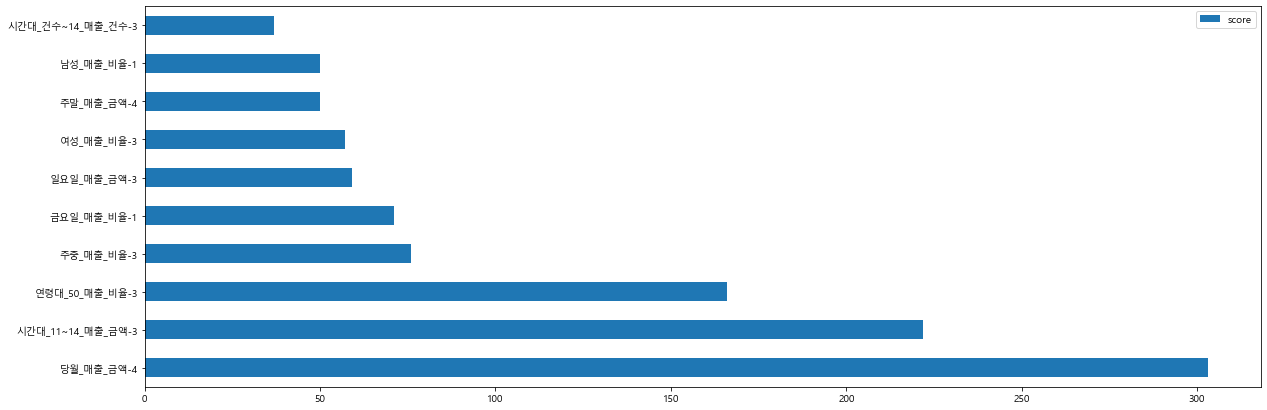

In [36]:
plt.rcParams['font.family'] = 'Malgun Gothic'
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')

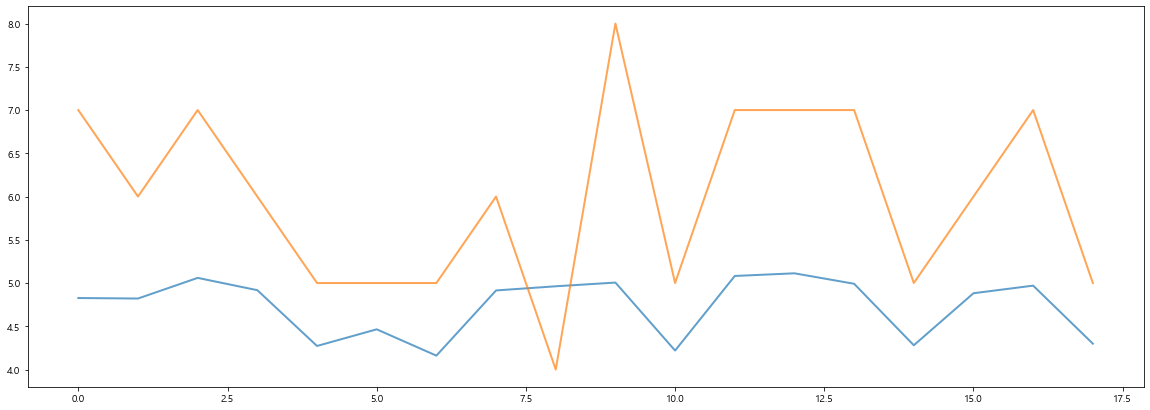

In [37]:
plt.pyplot.plot(model.predict(x_in),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out.values,alpha = 0.7,linewidth = 2)